# Unit 3 Final Project

Before you get started on your project, take a moment to review how you can make requests from the following APIs:
- **ESPN**
- **TikTok**
- **X**
- **Spotify**

First, you will need to set up your API credentials:
   - **Spotify**: `SPOTIFY_CLIENT_ID` and `SPOTIFY_CLIENT_SECRET` from https://developer.spotify.com/dashboard
   - **X (Twitter)**: `X_BEARER_TOKEN` from https://developer.twitter.com/en/portal/dashboard
   - **TikTok**: No authentication required!
   - **ESPN**: No authentication required!

In [10]:
# Import required libraries
import requests
import json
import random
import asyncio
import os

## 1. Spotify API - Random Song

In [11]:
# Setup API authorization before making request
SPOTIFY_CLIENT_ID = "1219869df3fd432a9c76f63e380bd867"
SPOTIFY_CLIENT_SECRET = "28c99e89808e459c81befc4ca677d685"

# Get access token
auth_response = requests.post('https://accounts.spotify.com/api/token', {
    'grant_type': 'client_credentials',
    'client_id': SPOTIFY_CLIENT_ID,
    'client_secret': SPOTIFY_CLIENT_SECRET,
})

auth_data = auth_response.json()
access_token = auth_data['access_token']

headers = {
    'Authorization': f'Bearer {access_token}'
}

In [13]:
def fetch_tracks(query, headers, batches=5, batch_size=50):
    """Fetch multiple batches of tracks from Spotify Search API."""
    all_tracks = []
    
    for i in range(batches):
        offset = i * batch_size
        response = requests.get(
            "https://api.spotify.com/v1/search",
            headers=headers,
            params={
                "q": query,
                "type": "track",
                "limit": batch_size,
                "offset": offset
            }
        )

        data = response.json()
        items = data.get("tracks", {}).get("items", [])
        all_tracks.extend(items)

        # Stop early if no more results
        if len(items) < batch_size:
            break

    return all_tracks


# ----- CLASSIC ROCK -----

classic_tracks = fetch_tracks("classic rock", headers, batches=20)

five_minutes_ms = 5 * 60 * 1000

total_classic = len(classic_tracks)
classic_over_5 = sum(1 for t in classic_tracks if t["duration_ms"] > five_minutes_ms)
proportion_classic = classic_over_5 / total_classic if total_classic > 0 else 0

print(f"Fetched classic rock tracks: {total_classic}")
print(f"Long classic rock tracks (>5 min): {classic_over_5}")
print(f"Proportion: {proportion_classic:.3f}")


Fetched classic rock tracks: 397
Long classic rock tracks (>5 min): 83
Proportion: 0.209


In [14]:
# ----- MODERN ROCK -----

modern_tracks = fetch_tracks("modern rock", headers, batches=20)

five_minutes_ms = 5 * 60 * 1000

total_modern = len(modern_tracks)
modern_over_5 = sum(1 for t in modern_tracks if t["duration_ms"] > five_minutes_ms)
proportion_modern = modern_over_5 / total_modern if total_modern > 0 else 0

print(f"Fetched modern rock tracks: {total_modern}")
print(f"Long modern rock tracks (>5 min): {modern_over_5}")
print(f"Proportion: {proportion_modern:.3f}")


Fetched modern rock tracks: 399
Long modern rock tracks (>5 min): 24
Proportion: 0.060


In [18]:
import random

def bootstrap_proportions(tracks, num_samples=1000, sample_size=100):
    five_min_ms = 5 * 60 * 1000
    proportions = []

    for _ in range(num_samples):
        sample = random.choices(tracks, k=sample_size)
        count_long = sum(1 for t in sample if t["duration_ms"] > five_min_ms)
        proportions.append(count_long / sample_size)

    return proportions

# Generate bootstrap distributions
classic_props = bootstrap_proportions(classic_tracks, num_samples=1000, sample_size=100)
modern_props = bootstrap_proportions(modern_tracks, num_samples=1000, sample_size=100)


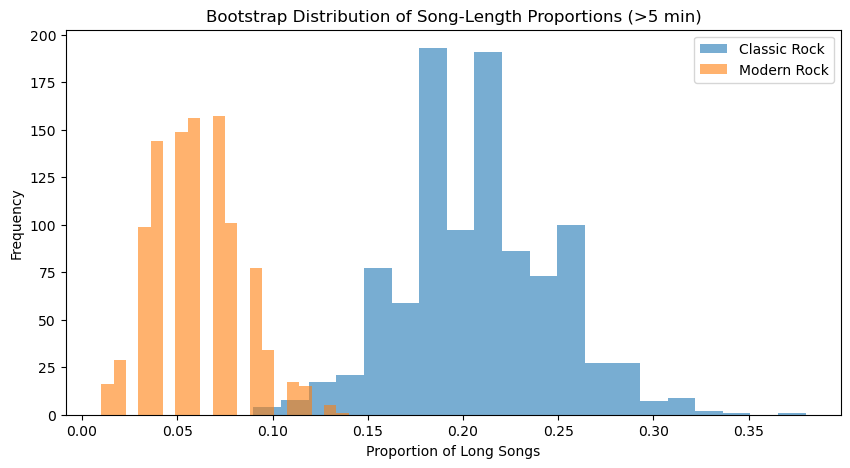

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.hist(classic_props, bins=20, alpha=0.6, label="Classic Rock")
plt.hist(modern_props, bins=20, alpha=0.6, label="Modern Rock")

plt.title("Bootstrap Distribution of Song-Length Proportions (>5 min)")
plt.xlabel("Proportion of Long Songs")
plt.ylabel("Frequency")
plt.legend()

plt.show()


In [16]:
import math

# helper normal CDF & inverse (using erf)
def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def norm_inv(p):
    # approximate inverse using binary search (very accurate)
    low, high = -10.0, 10.0
    for _ in range(60):
        mid = (low + high) / 2
        if norm_cdf(mid) < p:
            low = mid
        else:
            high = mid
    return (low + high) / 2

# -----------------------------
# compute proportions and pooled estimate
p_c = classic_over_5 / total_classic if total_classic > 0 else 0
p_m = modern_over_5 / total_modern if total_modern > 0 else 0
p_pool = (classic_over_5 + modern_over_5) / (total_classic + total_modern)

# z statistic for two-proportion test (H1: p_c > p_m, one-sided)
num = p_c - p_m
den = math.sqrt(p_pool * (1 - p_pool) * (1/total_classic + 1/total_modern))
z = num / den if den > 0 else float('nan')

# one-sided p-value (greater)
p_value_one_sided = 1 - norm_cdf(z)

# Print results
print("Observed proportions:")
print(f"  p_c (classic) = {p_c:.4f}  ({classic_over_5}/{total_classic})")
print(f"  p_m (modern)  = {p_m:.4f}  ({modern_over_5}/{total_modern})")
print()
print("Hypotheses:")
print("  H0: p_c = p_m")
print("  H1: p_c > p_m  (one-sided)")
print()
print(f"Z statistic = {z:.4f}")
print(f"One-sided p-value = {p_value_one_sided:.4f}")


Observed proportions:
  p_c (classic) = 0.2091  (83/397)
  p_m (modern)  = 0.0602  (24/399)

Hypotheses:
  H0: p_c = p_m
  H1: p_c > p_m  (one-sided)

Z statistic = 6.1586
One-sided p-value = 0.0000


### 🚀 YOUR TURN! Design Your Own Study
Now it's time to use one of the APIs above to collect real data and answer your own question!

Instructions:
- **My Question:** Write a clear research question that requires concepts covered in Unit 3 to analyze.
- **My Study:** State the API you will be using. Then, describe how much data you will randomly collect from the API.
- **My Analysis:** Perform the analysis you need. Remember, a level 4 requires 3 different techniques to be included in your analysis.
- **My Answer:** Interpret your results. Tell me what I should conclude from the specific visualizations you make and the specific values you find.

# 📝 My Hypothesis

*Write your research hypothesis here*

The proportion of classic rock songs greater than 5 minutes is bigger than the proportion of modern rock songs greater than 5 minutes. My null hypothesis would be if classic rock proportion is equal to the modern rock proportion, and my alternative hypothesis would be if the classic rock proportion is greater than or less than my modern rock proportion.

# 📊 My Study

*Describe your study design:*

- **What API are you using?** Spotify API
- **What will you measure?** Time length of songs
- **How much data will you randomly sample from the API?** 

# 🔬 My Analysis

# Perform your analysis here.

My question was a one sided test, checking if the proportions of classic rock songs over 5 minutes is longer than the proportion of modern rock songs over 5 minutes. My queries are independent as they take from two different queries of data.




# ✅ My Answer

Write your conclusion in complete sentences. Interpret specific values that you find and tell me what I should believe as a reader of your study. Assume I know nothing! Finally, include any limitations that you encountered while performing your analysis that may impact your results.